<a href="https://colab.research.google.com/github/ggrindstaff/Connectivity/blob/Automated-Earthwork-Detection/Colab_notebooks/earthwork_detection_PlottingCycles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies and import data

Install ripser package, cython dependency already available

In [ ]:
#!pip install ripser
!git clone https://github.com/ggrindstaff/ripser.py
%cd ripser.py
!pip install -e .

Cloning into 'ripser.py'...
remote: Enumerating objects: 3424, done.
remote: Counting objects: 100% (403/403), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 3424 (delta 192), reused 340 (delta 169), pack-reused 3021
Receiving objects: 100% (3424/3424), 20.33 MiB | 20.02 MiB/s, done.
Resolving deltas: 100% (1993/1993), done.
/content/ripser.py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/ripser.py
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 47 kB 4.2 MB/s 
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18120 sha256=fcb328dc67e53dd7a79df79966e1d016534c2d5ee5e4757d532515feba45ee22
  Stored in directory: /root/.cache/pip/wheels/d2/9f/a8/67f1b86e47cd17338d3d07939f4660378e65b758c4594f96e3
Successfully built hopcroftkarp
  Runnin

Code based on 
https://ripser.scikit-tda.org/en/latest/notebooks/Lower%20Star%20Image%20Filtrations.html

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from matplotlib.transforms import Affine2D
import scipy
from scipy import ndimage
import PIL
import random


from persim import plot_diagrams, bottleneck, sliced_wasserstein, wasserstein, bottleneck_matching, PersImage,PersistenceImager, landscapes
from ripser import ripser, lower_star_img, Rips
from persim.persistent_entropy import *
from scipy import stats
from scipy import sparse


plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline 

In [ ]:
def img_to_sparse(img):
  # Modified from source code
    m, n = img.shape

    idxs = np.arange(m * n).reshape((m, n))

    I = idxs.flatten()
    J = idxs.flatten()
    V = img.flatten()

    # Connect 8 spatial neighbors
    tidxs = np.ones((m + 2, n + 2), dtype=np.int64) * np.nan
    tidxs[1:-1, 1:-1] = idxs

    tD = np.ones_like(tidxs) * np.nan
    tD[1:-1, 1:-1] = img

    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:

            if di == 0 and dj == 0:
                continue

            thisJ = np.roll(np.roll(tidxs, di, axis=0), dj, axis=1)
            thisD = np.roll(np.roll(tD, di, axis=0), dj, axis=1)
            thisD = np.maximum(thisD, tD)

            # Deal with boundaries
            boundary = ~np.isnan(thisD)
            thisI = tidxs[boundary]
            thisJ = thisJ[boundary]
            thisD = thisD[boundary]

            I = np.concatenate((I, thisI.flatten()))
            J = np.concatenate((J, thisJ.flatten()))
            V = np.concatenate((V, thisD.flatten()))

    return sparse.coo_matrix((V, (I, J)), shape=(idxs.size, idxs.size))


def cocycles_to_plot(cocycles,d,rotate=False):
  m,n = d.shape
  birthloc = [cocycles[0][i][0][0] for i in range(len(cocycles[0]))]
  xloc = []
  yloc = []
  for ind in birthloc:
    if rotate==False:
      yi = int(ind/n)
      xi = ind%n
    if rotate==True:
      yi = m-int(ind/n)-1
      xi = ind%n  
    xloc.append(xi)
    yloc.append(yi)
  return xloc,yloc


# Load data and compute persistence diagrams

Takes about 0.07 seconds per image, for 100x100 pixel images. For berm data, about 6 seconds per image.

In [ ]:
directory = 'https://raw.githubusercontent.com/ggrindstaff/Connectivity/master/'#/content/Connectivity/Berms/'

files = ['landscape_clip_AOIs/AOI1_stockpond_clip.csv',
         'landscape_clip_AOIs/AOI2_berms_clip.csv',
         'landscape_clip_AOIs/AOI2_stockpond_clip.csv',
         'landscape_clip_AOIs/AOI3_stockpond_clip2.csv',
         'landscape_clip_AOIs/AOI3_berms_clip.csv',
         'landscape_clip_AOIs/AOI5_berms_clip.csv'  ,
                
         ]
multfac = 1#e5
N=len(files)

import scipy.ndimage

dgm0 = {i:[] for i in range(N)} # output 0th homology data
dgm0_adj= {i:[] for i in range(N)} # output 0th homology data
dgm1 = {i:[] for i in range(N)} # output 1th homology data
data = {i:[] for i in range(N)} # DEM data for examples
data2 = {i:[] for i in range(N)} # DEM data with noise for examples
cocycles = {i:[] for i in range(N)}
# sigmas = {0:[3,3],2:[.5,.5],3:[.5,.5]}

for i in range(N):
  try:
    data[i] = np.loadtxt(directory+files[i],delimiter=",",skiprows=1)
  except:
    data[i] = np.loadtxt(directory+files[i],delimiter=" ",skiprows=0)
    data_temp = [data[i][j][2] for j in range(len(data[i]))]
    data_shape = [p for p in data[i] if p[1]==data[i][0][1]]
    data_shape = len(data_shape)
    data_shape1 = len(data_temp)/data_shape
    data_temp = np.array(data_temp).reshape(int(data_shape1),int(data_shape))
    data[i] = data_temp
  if i>3:
    d = ndimage.interpolation.zoom(data[i],.5) #decimate resolution
  else:
    d = data[i]
  data2[i] = d + 1e-15*np.random.rand(d.shape[0],d.shape[1])
  if 'stockpond' in files[i]:
    sparseDM = img_to_sparse(data2[i])
    rip = ripser(sparseDM, distance_matrix=True, maxdim=0, do_cocycles=True)
    dgm0[i] = rip["dgms"][0]
    cocycles[i] = rip["cocycles"]
  else:
    sparseDM = img_to_sparse(data2[i])
    rip = ripser(-sparseDM, distance_matrix=True, maxdim=0, do_cocycles=True)
    dgm0[i] = rip["dgms"][0]
    cocycles[i] = rip["cocycles"]

#Plot cycle locations

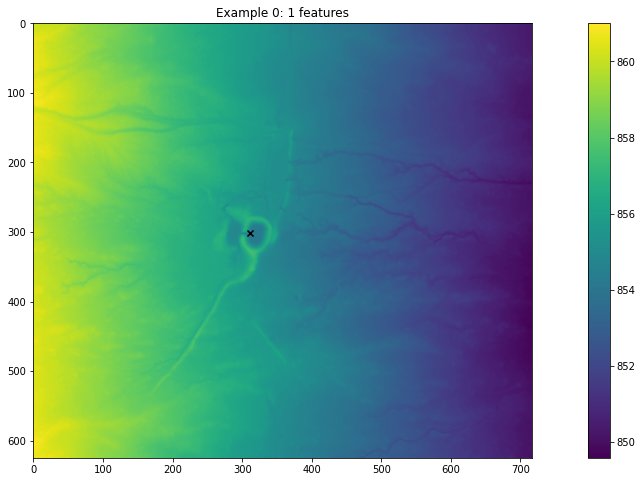

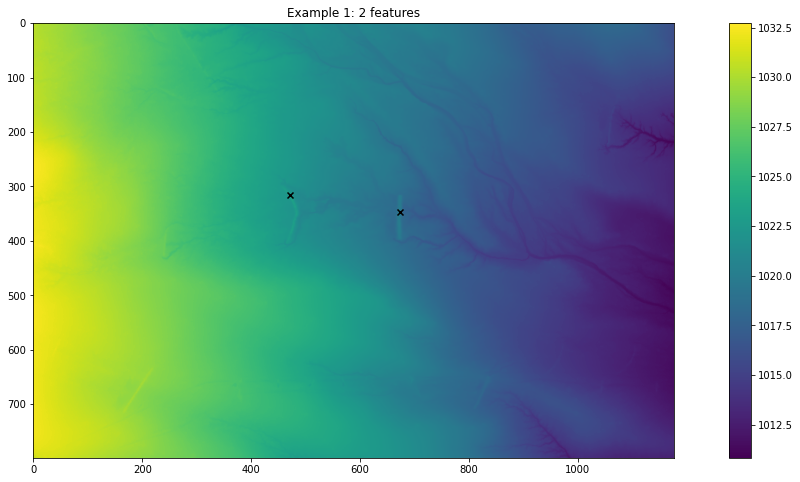

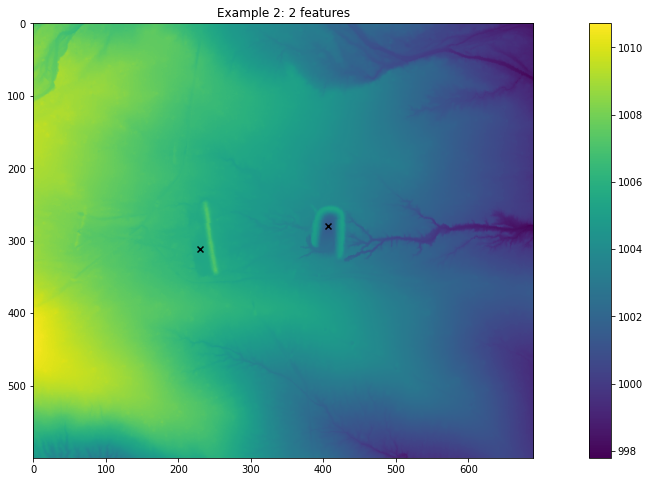

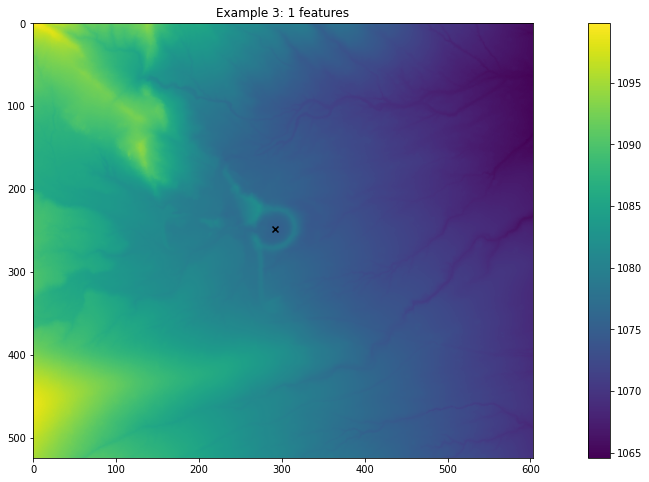

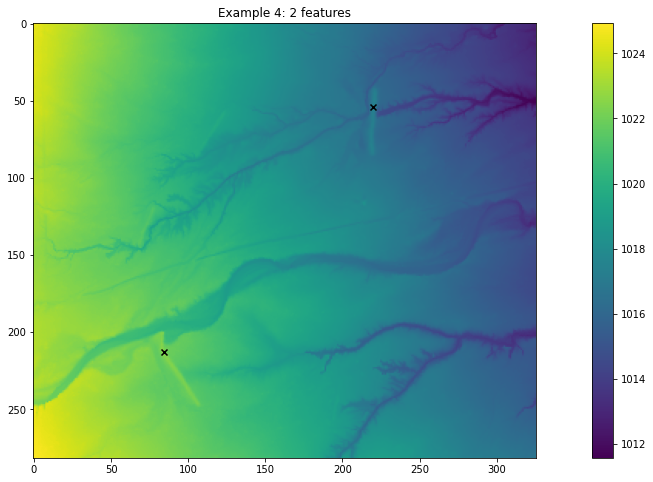

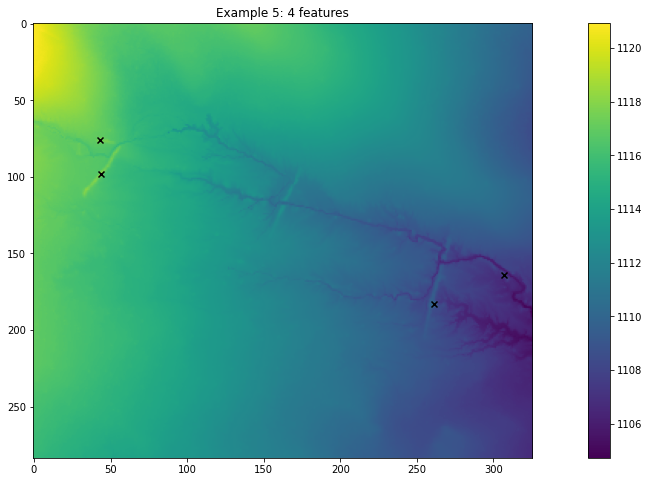

In [ ]:
# plot cycle locations on DEM data

thresh = 0.6 #these should be the min and max height that a berm would be relative to its surroundings
max_thresh = 3
# outlier_pond = 8
# outlier = 3
# outlier_perc = 95

noisethresh = 5

xcycles = {i:[] for i in range(N)}
ycycles = {i:[] for i in range(N)}
feature_idx = {i:[] for i in range(N)}
nonoise_idx = {i:[] for i in range(N)}

for i in range(len(files)):
  
  if 'stockpond' in files[i]:
    dgm = dgm0[i]
    idxs = np.arange(dgm.shape[0])
    idxs = idxs[np.abs(dgm[:, 1] - dgm[:, 0]) > thresh]
    # diffs = np.abs(dgm[:, 1] - dgm[:, 0])
    # mask = np.isfinite(diffs)
    # idxs = idxs[diffs>np.nanmedian(diffs[mask])+outlier_pond*np.std(diffs[mask])]
    # print('percentile:',np.nanpercentile(diffs[mask],outlier_perc),outlier_pond*np.std(diffs[mask]))
    # idxs = idxs[diffs>np.nanpercentile(diffs[mask],outlier_perc)+outlier_pond*np.std(diffs[mask])]
  else:
    dgm = dgm0[i]
    idxs = np.arange(dgm0[i].shape[0])
    idxs = idxs[np.abs(dgm0[i][:, 1] - dgm0[i][:, 0]) > thresh]
    # diffs = np.abs(dgm[:, 1] - dgm[:, 0])
    # mask = np.isfinite(diffs)
    # idxs = idxs[diffs>np.nanmedian(diffs[mask])+outlier*np.std(diffs[mask])]
    # idxs = idxs[diffs>np.nanpercentile(diffs[mask],outlier_perc)+outlier*np.std(diffs[mask])]

  xvals, yvals = cocycles_to_plot(cocycles[i],data2[i],rotate=False)
  xcycle, ycycle = np.array(xvals), np.array(yvals)
  mask1 = (xcycle>noisethresh)&(xcycle<len(data2[i][0])-noisethresh)&(ycycle>noisethresh)&(ycycle<len(data2[i])-noisethresh)
  nonoise_idx[i] = mask1
  xcycle = np.array(xvals)[idxs]
  ycycle = np.array(yvals)[idxs]
  mask = (xcycle>noisethresh)&(xcycle<len(data2[i][0])-noisethresh)&(ycycle>noisethresh)&(ycycle<len(data2[i])-noisethresh)
  xcycle = xcycle[mask]
  ycycle = ycycle[mask]
  xcycles[i] = xcycle
  ycycles[i] = ycycle
  feature_idx[i] = idxs[mask]

  plt.figure(figsize = (20,8))
  shw = plt.imshow(data2[i], cmap = 'viridis')
  if i==6:
    shw = plt.imshow(data2[i],cmap='viridis',vmin=997,vmax = 1007)
  plt.scatter(xcycle,ycycle,c='k', marker='x')
  plt.title('Example ' + str(i) +': '+str(len(xcycle))+' features')
  # plt.axis('off')
  plt.colorbar(shw)
  plt.show()

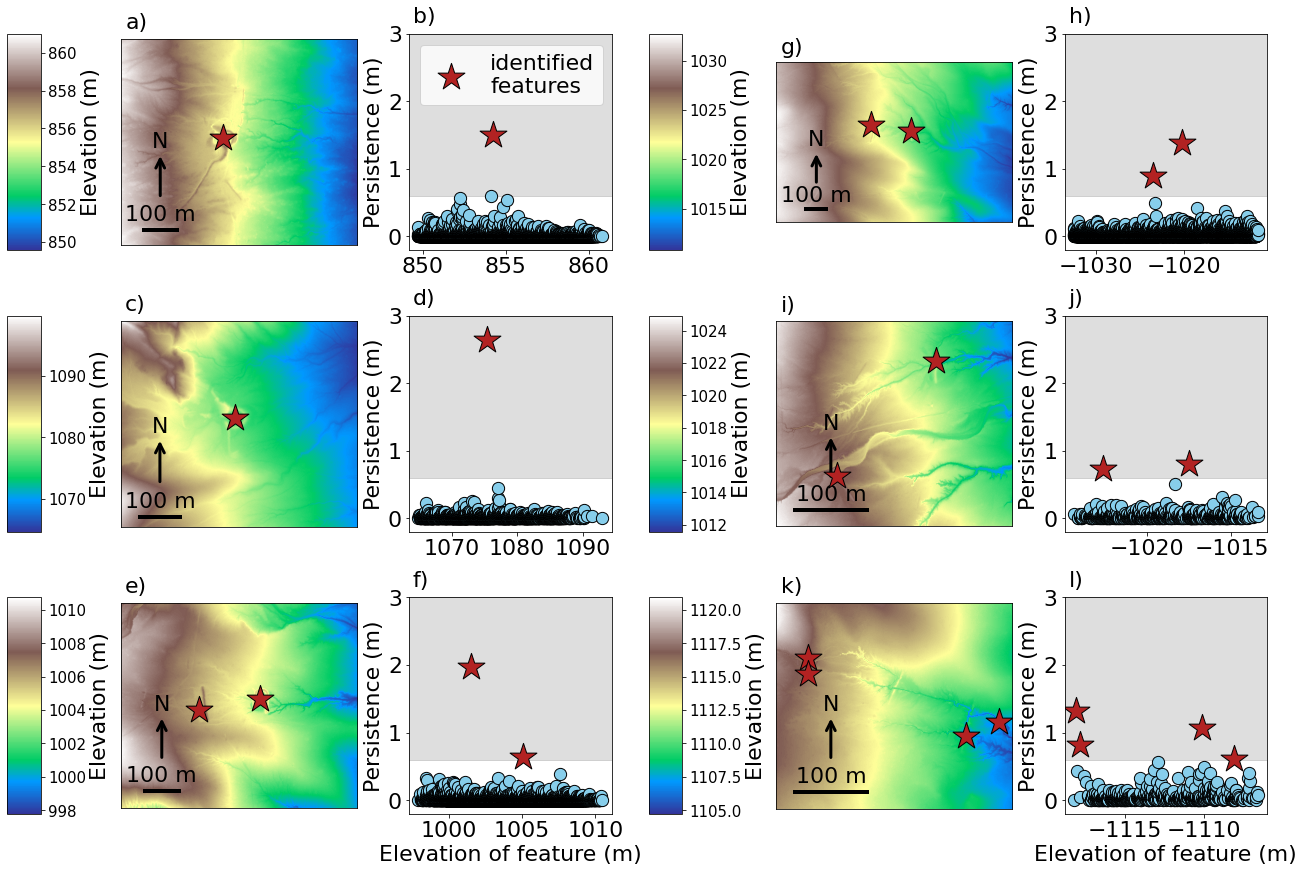

In [ ]:
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.rcParams.update({'font.size': 22})

cmap='terrain'

fig2 = plt.figure(constrained_layout=True, figsize = (18,12))
spec2 = gridspec.GridSpec(ncols=28, nrows=3, figure=fig2)
#colorbars
ax0  = fig2.add_subplot(spec2[0, 0])
ax01 = fig2.add_subplot(spec2[1, 0])
ax02 = fig2.add_subplot(spec2[0, 14])
ax03 = fig2.add_subplot(spec2[1, 14])
ax04 = fig2.add_subplot(spec2[2, 0])
ax05 = fig2.add_subplot(spec2[2, 14])
# elevation maps
ax1 = fig2.add_subplot(spec2[0, 1:8]) 
ax2 = fig2.add_subplot(spec2[1, 1:8]) 
ax3 = fig2.add_subplot(spec2[0, 15:22]) 
ax4 = fig2.add_subplot(spec2[1, 15:22]) 
ax5 = fig2.add_subplot(spec2[2, 1:8]) 
ax51 = fig2.add_subplot(spec2[2, 15:22]) 
# persistence diagrams
ax6 = fig2.add_subplot(spec2[0, 8:14]) 
ax7 = fig2.add_subplot(spec2[1, 8:14]) 
ax8 = fig2.add_subplot(spec2[0, 22:]) 
ax9 = fig2.add_subplot(spec2[1, 22:]) 
ax10 = fig2.add_subplot(spec2[2, 8:14]) 
ax11 = fig2.add_subplot(spec2[2, 22:]) 

axs = [[ax0,  ax1, ax6],
       [ax01, ax2, ax7],
       [ax02, ax3, ax8],
       [ax03, ax4, ax9],
       [ax04, ax5, ax10],
       [ax05, ax51, ax11]
       ]
scale_y = [580,500,735,260,550,260]
scale_x = [120,100,200,75,120,75]
dataind = [0,3,1,4,2,5]
label0=['a)','c)','g)','i)','e)','k)']
label1 = ['b)','d)','h)','j)','f)','l)']
tick_font_size = 15
for i in range(6):
  ax = axs[i][1]
  d = data2[dataind[i]]
  terr = ax.imshow(d,cmap = cmap)
  cbar = plt.colorbar(terr, cax = axs[i][0])
  cbar.set_label('Elevation (m)')
  cbar.ax.tick_params(labelsize=tick_font_size)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.plot([scale_x[i]-50,scale_x[i]+50],[scale_y[i]]*2,lw=4,c = 'k')
  ax.text(scale_x[i],scale_y[i]*0.95,'100 m',horizontalalignment='center')
  ax.annotate('N', (scale_x[i], scale_y[i]*0.83),
            xytext=(scale_x[i], scale_y[i]*0.57),
             arrowprops=dict(facecolor='black', 
                             arrowstyle='<-',
                             lw = 3),ha='center')
  ax.scatter(xcycles[dataind[i]],ycycles[dataind[i]],
             c='firebrick',marker = '*',s=800,edgecolor = 'k',
             label = 'identified\nfeatures',
             zorder = 100)
  # if i==0:
  #   ax.legend(loc='upper left')
  ax.text(0.02,1.05,label0[i],transform = ax.transAxes)
  
  # plot persistence diagrams
  ax = axs[i][2]
  dgm = dgm0[dataind[i]]
  birth = np.array([p[0] for p in dgm])
  death = np.array([p[1] for p in dgm])
  pers = death-birth
  mask_feature = feature_idx[dataind[i]]
  mask1 = nonoise_idx[dataind[i]]
  birthplotfeature = birth[mask_feature]
  persplotfeature = pers[mask_feature]

  t = 0.6
  birth = birth[pers<t]
  mask1 = mask1[pers<t]
  pers = pers[pers<t]

  ax.scatter(birth[mask1],
             pers[mask1],
             c='skyblue',edgecolor = 'k',
             s = 150,
            #  label = 'background'
             )
  ax.scatter(birthplotfeature,persplotfeature,
             label = 'identified\nfeatures',
             c='firebrick',edgecolor = 'k',s=800,
             marker = '*',)
  ax.set_ylabel('Persistence (m)')
  ax.axhspan(thresh,max_thresh,facecolor='k',alpha=0.13,edgecolor = 'k',zorder = -1)
  
  if i==0:
    ax.legend(loc='upper left',)
  ax.text(0.02,1.05,label1[i],transform = ax.transAxes)
  ax.set_ylim(-.2,3)

for ax in [ax10,ax11]:
  ax.set_xlabel('Elevation of feature (m)')
plt.savefig('real_feature_detection.png',format='png',
            dpi=300,bbox_inches='tight')